# Gene Regulatory Network Tutorial

In this tutorial we run through GRN graph construction in Graphein. This works by providing a `gene_list` containing gene names. The interactions between these genes are retrieved from two possible sources:
* TRRUST
* RegNetwork

This is controlled by providing an edge construction function (`add_trrust_edges` and `add_regnetwork_edges`) respectively.

In [1]:
import networkx as nx
from functools import partial
from typing import List
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)
from easydev import Logging as elogging
elogging.level = "CRITICAL"

from graphein.grn.edges import add_regnetwork_edges, add_trrust_edges

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


## Config Objects
Global parameters are stored in Config objects. We have a global `GRNGraphConfig` that contains a `TRRUSTConfig` and a `RegNetworkConfig` for parameters relating to each of the two sources.

In [2]:
# Initialise Config Object
from graphein.grn.config import GRNGraphConfig
config = GRNGraphConfig()
print(f"GRN Config: \n{config} \n")
print(f"TRRUST Config: \n{config.trrust_config} \n")
print(f"RegNetwork Config: \n{config.regnetwork_config}")

GRN Config: 
kwargs={} trrust_config=TRRUSTConfig(filtering_functions=None, root_dir=None, kwargs=None) regnetwork_config=RegNetworkConfig(filtering_functions=None, root_dir=None, kwargs=None) 

TRRUST Config: 
filtering_functions=None root_dir=None kwargs=None 

RegNetwork Config: 
filtering_functions=None root_dir=None kwargs=None


## Gene List
This is the list of genes that we wish to construct a GRN graph for

In [3]:
gene_list: List[str] = ["AATF", "MYC", "USF1", "SP1", "TP53", "DUSP1"]

## Edge Annotation Functions
These are functions that determine labelling of edges with additional metadata. Here we define one which assigs:
    * `"+"` to upregulatory interactions
    * `"-"` to downregulatory interactions
    * `"?"` to interactons of unknown directionality
    
Edge Annotation functions take in two nodes (`u`, `v`) and the edge data (`d`)

In [4]:
# This function defines the labelling of regulatory directions
def edge_ann_fn(u, v, d):
    if "+" in d["regtype"]:
        d["regtype"] = "+"
    elif "-" in d["regtype"]:
        d["regtype"] = "-"
    elif "?" in d["regtype"]:
        d["regtype"] = "?"

## Graph Construction

In [5]:
from graphein.grn.graphs import compute_grn_graph
from graphein.grn.features.node_features import add_sequence_to_nodes

g = compute_grn_graph(
    gene_list=gene_list,
    edge_construction_funcs=[
        partial(add_trrust_edges, trrust_filtering_funcs=config.trrust_config.filtering_functions),
        partial(add_regnetwork_edges, regnetwork_filtering_funcs=config.regnetwork_config.filtering_functions),
    ],
    node_annotation_funcs=[add_sequence_to_nodes],#, molecular_weight],
    edge_annotation_funcs=[edge_ann_fn],
)

/home/atj39/anaconda3/envs/graphein-dev/lib/python3.8/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/home/atj39/github/graphein/graphein/grn/parse_regnetwork.py:137: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  df = load_RegNetwork_interactions(root_dir)


/home/atj39/github/graphein/graphein/grn/parse_regnetwork.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["source"] = "RegNetwork"


In [6]:
for n,d in g.nodes(data=True):
    print(n, d)

AATF {'gene_id': 'AATF', 'uniprot_ids': ['Q9NY61'], 'sequence_Q9NY61': 'MAGPQPLALQLEQLLNPRPSEADPEADPEEATAARVIDRFDEGEDGEGDFLVVGSIRKLASASLLDTDKRYCGKTTSRKAWNEDHWEQTLPGSSDEEISDEEGSGDEDSEGLGLEEYDEDDLGAAEEQECGDHRESKKSRSHSAKTPGFSVQSISDFEKFTKGMDDLGSSEEEEDEESGMEEGDDAEDSQGESEEDRAGDRNSEDDGVVMTFSSVKVSEEVEKGRAVKNQIALWDQLLEGRIKLQKALLTTNQLPQPDVFPLFKDKGGPEFSSALKNSHKALKALLRSLVGLQEELLFQYPDTRYLVDGTKPNAGSEEISSEDDELVEEKKQQRRRVPAKRKLEMEDYPSFMAKRFADFTVYRNRTLQKWHDKTKLASGKLGKGFGAFERSILTQIDHILMDKERLLRRTQTKRSVYRVLGKPEPAAQPVPESLPGEPEILPQAPANAHLKDLDEEIFDDDDFYHQLLRELIERKTSSLDPNDQVAMGRQWLAIQKLRSKIHKKVDRKASKGRKLRFHVLSKLLSFMAPIDHTTMNDDARTELYRSLFGQLHPPDEGHGD'}
MYC {'gene_id': 'MYC', 'uniprot_ids': ['P01106'], 'sequence_P01106': 'MPLNVSFTNRNYDLDYDSVQPYFYCDEEENFYQQQQQSELQPPAPSEDIWKKFELLPTPPLSPSRRSGLCSPSYVAVTPFSLRGDNDGGGGSFSTADQLEMVTELLGGDMVNQSFICDPDDETFIKNIIIQDCMWSGFSAAAKLVSEKLASYQAARKDSGSPNPARGHSVCSTSSLYLQDLSAAASECIDPSVVFPYPLNDSSSPKSCASQDSSAFSPSSDSLLSSTESSPQGSPEPLVLHEETPPTTSSDSEEEQEDEEEIDVVSVEKRQAPGKRSESGSPSAGGHSKPPHSPL

## Plotting the Graph
We now wish to visualise the graph. We can do this with the built in visualisation in NetworkX

DiGraph with 6 nodes and 22 edges


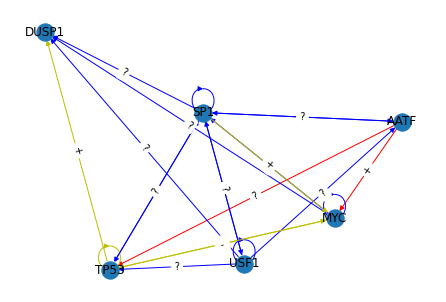

In [7]:
# Here we define a colouring scheme for the graph
edge_colors = [
    "r"
    if g[u][v]["kind"] == {"trrust"}
    else "b"
    if g[u][v]["kind"] == {"regnetwork"}
    else "y"
    for u, v in g.edges()
]

print(nx.info(g))

pos = nx.spring_layout(g)
nx.draw(g, pos=pos, with_labels=True, edge_color=edge_colors)
edge_labels = {(u, v): g[u][v]["regtype"] for u, v in g.edges}
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=edge_labels)
plt.show()

In [8]:
print(g.edges(data=True))

[('AATF', 'MYC', {'kind': {'trrust'}, 'regtype': '+'}), ('AATF', 'TP53', {'kind': {'trrust'}, 'regtype': '?'}), ('AATF', 'SP1', {'kind': {'regnetwork'}, 'regtype': '?'}), ('MYC', 'TP53', {'kind': {'trrust', 'regnetwork'}, 'regtype': '+'}), ('MYC', 'DUSP1', {'kind': {'regnetwork'}, 'regtype': '?'}), ('MYC', 'SP1', {'kind': {'regnetwork'}, 'regtype': '?'}), ('MYC', 'MYC', {'kind': {'regnetwork'}, 'regtype': '?'}), ('USF1', 'DUSP1', {'kind': {'regnetwork'}, 'regtype': '?'}), ('USF1', 'USF1', {'kind': {'regnetwork'}, 'regtype': '?'}), ('USF1', 'SP1', {'kind': {'regnetwork'}, 'regtype': '?'}), ('USF1', 'TP53', {'kind': {'regnetwork'}, 'regtype': '?'}), ('USF1', 'AATF', {'kind': {'regnetwork'}, 'regtype': '?'}), ('SP1', 'MYC', {'kind': {'trrust', 'regnetwork'}, 'regtype': '+'}), ('SP1', 'TP53', {'kind': {'regnetwork'}, 'regtype': '?'}), ('SP1', 'AATF', {'kind': {'regnetwork'}, 'regtype': '?'}), ('SP1', 'DUSP1', {'kind': {'regnetwork'}, 'regtype': '?'}), ('SP1', 'USF1', {'kind': {'regnetwork'